In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from numpy import linspace, zeros

%matplotlib inline
plt.style.use('bmh')

# **Ejercicio 1**

Modifique el algoritmo de diferencias dinitas empleado anteriormente y resuelva la ecuación de onda amortiguada en una dimensión, dada pro la ecuación

$\frac {\partial ^{2} u}{\partial t^2} + b\frac {\partial u}{\partial t} = c^{2}(\frac {\partial ^{2} u}{\partial x^{2} })$  $x\in (0,L], t\in (0,T]$

donde $b\geq 0$ y $c$ son constantes.

Se proporcionan las condiciones iniciales y a la frontera para encontrar la solución.

$u(x,0) = I(x) \quad  (1)$\
$\frac {\partial}{\partial t} u(x,0) = 0 \quad (2)$\
$u(0,t) = 0 \quad (3)$\
$u(L,t) = 0 \quad (4)$

Utilice diferencias finitas centradas de segundo orden para aproximar la primer derivada $\frac {\partial u}{\partial t}$.

$\frac {\partial}{\partial t} u(x.t)\approx \frac {u(x,t + k) - u(x,t - k)}{2k}$

Suponga las mismas características del ejemplo presentado anteriormente $L = 10$, $c = 100\frac {m}{s}$, $b=0.5$ con condiciones iniciales $u(x,0) = x(1-x)$ y $\frac {\partial u(x,0)}{\partial t} = 0$ y condiciones a la frontera $u(0,t) = u(L,t) = 0$.




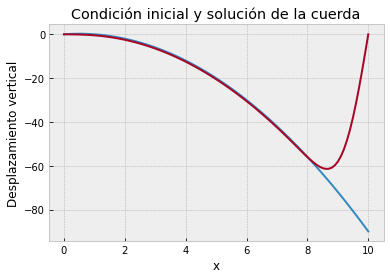

In [3]:
#Utilizamos la ecuación que resuelva la ecuación de onda utilizada en clase.
def solver(I, V, f, c, L, Nx, C, T, user_action=None):
    """Resuelve u_tt=c^2*u_xx + f sobre (0,L)x(0,T]."""
    x = linspace(0, L, Nx+1) # Malla en x
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1) # Malla en t
    C2 = C**2 # Simplificar la ecuación
    
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solución al nuevo tiempo
    u_1 = zeros(Nx+1) # Solución 1 paso atrás en el tiempo
    u_2 = zeros(Nx+1) # Solución 2 pasos atrás en el tiempo
    
    import time; 
    #t0 = time.clock() # Mediremos el tiempo de CPU
    t0 = time.process_time()

    # Cargar la condición inicial en u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Fórmula del primer paso
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], t[n])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Redefinimos variables para volver a utilizar
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Actualiza los valores en el tiempo t[n+1]
        for i in range(1, Nx):
            u[i] = (1/(1/dt**2+0.5/2*dt))*((c**2/dx**2)*(u[i+1]-2*u[i]+u[i-1])+(2*u[i]-u_1[i])/dt**2+(0.5/2*dt)*u_1[i])
        # Definimos la condición a la frontera
        u[0] = 0; u[Nx] = 0

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Redefinimos variables antes del siguiente paso
        u_2[:], u_1[:] = u_1, u

    # cpu_time = t0 - time.clock()
    cpu_time = time.process_time() - t0
    return u, x, t, cpu_time

def user_action(u, x, t, n):
    "Define una acción del usuario para guardar y visualizar posteriormente los datos."
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
      user_data['u'].append((t[n], u.copy()))

# Ejemplo de una cuerda vibrante L=1, t=(0,0.25), c=100m/s
# Variables solver(I, V, f, c, L, Nx, C, T, user_action=None)
# I = Condición Incial
# V = Velocidad Inicial
# f = función de forzamiento 
# c = Velocidad de propagación
# L = Longitud de la cuerda
# Nx = Núm. de puntos en x
# C = c*k/h Constante de Courant < 1
# T = Tiempo final de Integración

user_data = {}
u, x, t, cpu_time = solver(lambda x: x*(1-x), None, None, 100, 10, 100, 0.1, 0.25, user_action=user_action)
I = x*(1-x)
plt.xlabel("x")
plt.ylabel("Desplazamiento vertical")
plt.title("Condición inicial y solución de la cuerda")
plt.plot(x,I)
plt.plot(x,u)


In [4]:
#Grafica interactiva.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

duration = 20

fig, ax = plt.subplots(figsize=(4, 3), facecolor='white', dpi=92)
plt.tight_layout()

def make_frame_mpl(t):
    n = int(t / duration * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.plot(x, u)
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-80, 0.25)
    ax.set_xlabel('x (a. u.)')
    ax.set_ylabel('Desplazamiento vertical (a. u.)')
    return mplfig_to_npimage(fig) # imágen de la figura

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, width=600)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3170304/45929032 bytes (6.9%)5996544/45929032 bytes (13.1%)9199616/45929032 bytes (20.0%)12386304/45929032 bytes (27.0%)15646720/45929032 bytes (34.1%)18890752/45929032 bytes (41.1%)22102016/45929032 bytes (48.1%)25280512/45929032 bytes (55.0%)28573696/45929032 bytes (62.2%)31776768/45929032 bytes (69.2%)34783232/45929032 bytes (75.7%)37920768/45929032 bytes (82.6%)

100%|█████████▉| 400/401 [00:30<00:00, 13.22it/s]


# **Ejercicio 2**

Haga el desarrollo del algoritmo de diferencias finitas centradas para resolver la ecuación de onda en 1 diemnsión si se tiene un término de forzamiento $f(x,t)$

$\frac {\partial ^{2}u}{\partial t^{2}} = c^{2}(\frac {\partial ^{2} u}{\partial x^{2}}) + f(x,t) \quad x\in(0,Ll], t\in (0,T]$

Con las condiciones iniciales y a la frontera para encontrar la solución.

$u(x,0) = I(x) \quad (1)$\
$\frac {\partial u(x,0)}{\partial t} = 0 \quad (2)$\
$u(0,t) = 0 \quad (3)$\
$u(L,t) = 0 \quad (4)$\

$\frac {u^{n+1}_{j} - 2u^{n}_{j} + u^{n-1}_{j}}{k^{2}} = c{2}\frac {u^{n}_{j+1}-2u^{n}_{j} -u^{n}_{j-1}}{h^{2}}+f^{n}_{j}$

f depende de la posición y el tiempo que conocemos $f(x_{i},t_{n})$. Despejamos $u^{n+1}_{j} = 2u^{n}_{j} -u^{n-1}_{j} + \frac {k^{2}c^{2}}{h^{2}} [u^{n}_{j+1} - 2u^{n}_{j} - u^{n}_{j-1}] + k^{2} f^{n}_{j}$

ya que $u^{-1}_{j} no nos dan en la condición inicial, vamos a aproximar con la derivada siendo:

$\frac {\partial u}{\partial t} = \frac {u^{n+1}_{i} - u^{k-1}_{i}}{2k} = v_{0}$

De esto tenemos que:
$u^{n+1}_{i} - u^{n-1}_{i} = 2kv_0, n=0$\
$u^{1}_{i} - u^{1}_{i} = 2kv_0, n=0$\
$-u^{1}_{i} = 2lv_{0} - u^{1}_{i}$

Retomamos la segunda ecuación y sustituyendo:

$u^{1}_{j} = 2u^{n}_{j} - u^{-1}_{j} + \frac {k^{2}c^{2}}{h^2} [u^{0}_{j+1} - 2u^{0}_{j} - u^{0}_{j-1}]+k^{2}f^{0}_{j}$\
$u^{1}_{j} = 2u^{n}_{j} + 2kv_0 - u^{1}_{i} + \frac {k^{2}c^{2}}{h^2} [u^{0}_{j+1} - 2u^{0}_{j} - u^{0}_{j-1}]+k^{2}f^{0}_{j}$

Despejamos $u^{1}_{j}$:

$u^{1}_{j} + u^{1}_{i} = 2u^{n}_{j} + 2kv_0 + \frac {k^{2}c^{2}}{h^2}[u^{0}_{j+1} -2u^{0}_{j} - u^{0}_{j-1}]+k^{2}f^{0}_{j}$\
$2u^{1}_{j} = 2u^{n}_{j} + 2kv_0 + \frac {k^{2}c^{2}}{h^2}[u^{0}_{j+1} -2u^{0}_{j} - u^{0}_{j-1}] + \frac {k^{2}f^{0}_{j}}{2}$


In [12]:
def Solver( I, V, f, c, L, Nx, C, T, user_action = None ):

  #---- Resuelve u_tt=c^2*u_xx + f sobre (0,L)x(0,T) ----#

  x = np.linspace( 0, L, Nx + 1 )     #---- Malla en x ----#

  dx = x[ 1 ] - x[ 0 ]
  dt = C*dx/c
  Nt = int( round( T/dt ) )

  t = np.linspace( 0, Nt*dt, Nt + 1 ) #---- Malla en t ----#

  C2 = C**2
  
  if f is None or f == 0:
    f = lambda x, t: 0

  if V is None or V == 0:
    V = lambda x: 0

  u0 = zeros( Nx + 1 ) #---- Solución al nuevo tiempo ----#
  u1 = zeros( Nx + 1 ) #---- Solución 1 paso atrás en el tiempo ----#
  u2 = zeros( Nx + 1 ) #---- Solución 2 pasos atrás en el tiempo ----#

  import time;
    # t0 = time.clock()        #---- Mediremos el tiempo de CPU ----#
  t0 = time.process_time()

  for i in range( 0, Nx + 1 ): #---- Cargamos condiciones iniciales en u1 ----#
    u1[ i ] = I( x[ i ] )      #---- Condicion al tiempo 0 ----#

  if user_action is not None:
    user_action( u1, x, t, 0 )

  #---- Fórmula del primer paso ----#

  n = 0
  
  for i in range( 1, Nx ): # Permanece igual, al despeje para n=1 se elimina b #
    u0[ i ] = u1[ i ] + dt*V( x[ i ] ) + \
    0.5*C2*( u1[ i - 1 ] - 2*u1[ i ] + u1[ i + 1 ] ) + \
    0.5*dt**2*f( x[ i ], t[ n ] )
  u0[ 0 ] = 0; u0[ Nx ] = 0  #---- Condiciones a los extremos ----#

  if user_action is not None:
    user_action( u0, x, t, 1 )

  #---- Redefinimos variables para volver a utilizar ----#
  
  u2[ : ], u1[ : ] = u1, u0 

  for i in range( 1, Nt ): #- Actualiza los valores en el tiempo t[ n + 1 ] -#
    for i in range( 1, Nx ):
      u0[ i ] = -u2[ i ] + 2*u1[ i ] + \
      C2*( u1[ i - 1 ] - 2*u1[ i ] + u1[ i + 1 ] ) + \
      dt**2*f( x[ i ], t[ n ] )

    #---- Definimos la condición a la frontera ----#

    u0[ 0 ] = 0; u0[ Nx ] = 0

    if user_action is not None:
      if user_action( u0, x, t, n + 1 ):
        break

    #---- Redefinimos variables antes del siguiente paso ----#

    u2[ : ], u1[ : ] = u1, u0

  #---- cpu_time = t0 - time.clock() ----#

  cpu_time = t0 - time.process_time()
  return u0, x, t, cpu_time

#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\----------//////////////////////////////#

def user_action( u0, x, t, n ):
  #---- Define una acción del usuario para guardar ----# 
  #---- y visualizar posteriormente los datos ----#

  global user_data

  if 'x' not in user_data:
    user_data[ 'x' ] = x
  if 'u' not in user_data:
    user_data[ 'u' ] = [ ( n, u0 ) ]
  else:
    user_data[ 'u' ].append( ( t[ n ], u0.copy() ) )

# **Ejercicio 3**

Resuelva la ecuación KdV, para el caso de 2 solitones comenzando en $x01 = 0.25L$ y $x02 = 0.75L$, con velocidades $c1 = 0.75$ y $c2 = 0.01$ e integre hasta que una de las ondas llegue a la frontera.

Grafique las soluciones como en el ejemplo que se proporcionó.

In [6]:

import numpy as np
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias


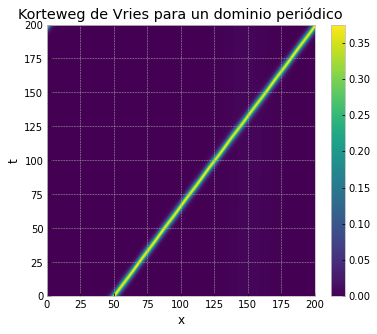

In [7]:
def kdv_exact(x,c):
  u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
  return u

def kdv(u, t, L):
  ux = psdiff(u, period=L)
  uxxx = psdiff(u, period=L, order=3)
  dudt = -6*u*ux - uxxx
  return dudt

def kdv_solution(u0, t, L):
  sol = odeint(kdv, u0, t, args = (L,), mxstep=5000)
  return sol

if __name__ == "__main__":
  L = 200.0
  Nx = 256
  dx = L / (Nx - 1.0)
  x = np.linspace(0, (1-1.0/Nx)*L, Nx)
  x01 = 0.25*L
  x02 = 0.75*L
  c1 = 0.75
  c2 = 0.01
  u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2)
  T = 200
  Nt = 501
  t = np.linspace(0, T, Nt)

  print("Calculando la solución.")
  sol = kdv_solution(u0, t, L)
  print("Graficando una representación de la interacción de 2 ondas solitarias")

  import matplotlib.pyplot as plt
  plt.figure(figsize=(6,5))
  plt.imshow(sol[::-1, :], extent=[0,L,0,T])
  plt.colorbar()
  plt.xlabel("x")
  plt.ylabel("t")
  plt.axis("auto")
  plt.title("Korteweg de Vries para un dominio periódico")
  plt.show()

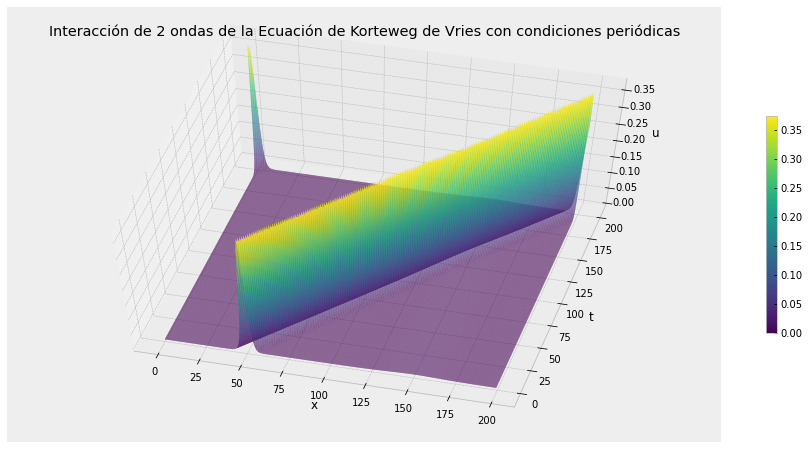

In [8]:
#Grafica en 3d.
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection="3d")
SX, ST = np.meshgrid(x, t)
ax.plot_surface(SX, ST, sol, cmap="viridis", rstride=1, cstride=1, alpha=0.75)

m = cm.ScalarMappable(cmap="viridis")
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")
ax.view_init(elev=60, azim=-75)
ax.set_title("Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas")
plt.show()

# **Ejercicio 4**

Resuelva la Ecuación Kdv, para el caso de 3 solitones comenzando en $x01=0.25L$, $x02=0.5L$ y $x03=0.75L$, con velocidades $c1=0.75$, $c2=0.5$ y $c3=0.25$ e integre hasta que una de las ondas llegue a la frontera.\
Grafique las soluciones.

In [9]:
import numpy as np
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias


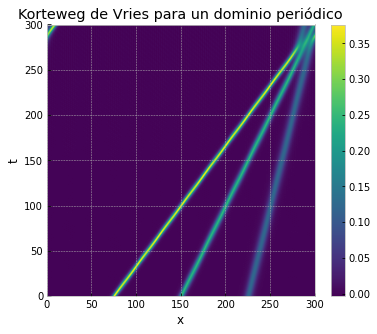

In [10]:
def kdv_exact(x,c):
  u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
  return u

def kdv(u, t, L):
  ux = psdiff(u, period=L)
  uxxx = psdiff(u, period=L, order=3)
  dudt = -6*u*ux - uxxx
  return dudt

def kdv_solution(u0, t, L):
  sol = odeint(kdv, u0, t, args = (L,), mxstep=5000)
  return sol

if __name__ == "__main__":
  L = 300.0
  Nx = 256
  dx = L / (Nx - 1.0)
  x = np.linspace(0, (1-1.0/Nx)*L, Nx)
  x01 = 0.25*L
  x02 = 0.50*L
  x03 = 0.75*L
  c1 = 0.75
  c2 = 0.50
  c3 = 0.25
  u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) + kdv_exact(x-x03, c3)
  T = 300
  Nt = 501
  t = np.linspace(0, T, Nt)

  print("Calculando la solución.")
  sol = kdv_solution(u0, t, L)
  print("Graficando una representación de la interacción de 2 ondas solitarias")

  import matplotlib.pyplot as plt
  plt.figure(figsize=(6,5))
  plt.imshow(sol[::-1, :], extent=[0,L,0,T])
  plt.colorbar()
  plt.xlabel("x")
  plt.ylabel("t")
  plt.axis("auto")
  plt.title("Korteweg de Vries para un dominio periódico")
  plt.show()

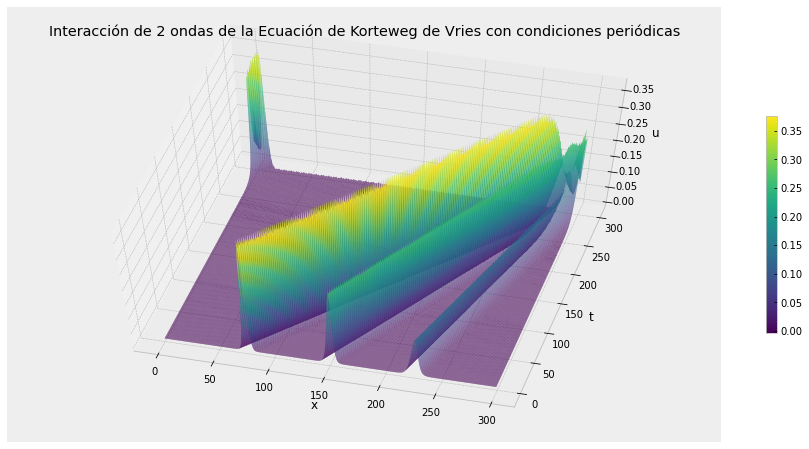

In [11]:
#Gráfica 3d.
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection="3d")
SX, ST = np.meshgrid(x, t)
ax.plot_surface(SX, ST, sol, cmap="viridis", rstride=1, cstride=1, alpha=0.75)

m = cm.ScalarMappable(cmap="viridis")
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")
ax.view_init(elev=60, azim=-75)
ax.set_title("Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas")
plt.show()


# **Ejercicio 5**

En el ejemplo resuelto anterior, se mostró la evolución de la condición inicial.

$u^{(2,1)}_{0} (x; y, 0)=Sin(\pi x)Sin(\frac {\pi y}{2})$

mostrando el modo $(1,2)$ de oscilación natural de la membrana.\ En este ejercicio se pide mostrar la evolución del modo (1,1), con la condición inicial

$u^{(1,1)}_{0} (x,y,0)=Sin(\frac {\pi x}{2})Sin(\frac {\pi y}{2})$

In [13]:
#!python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


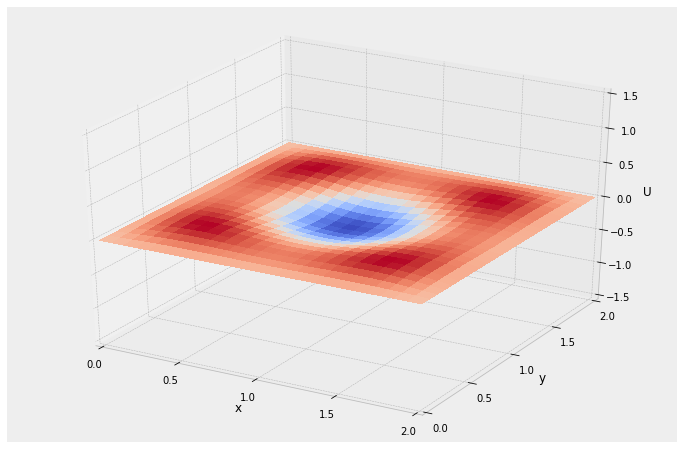

paso: 10.0 t= 0.285


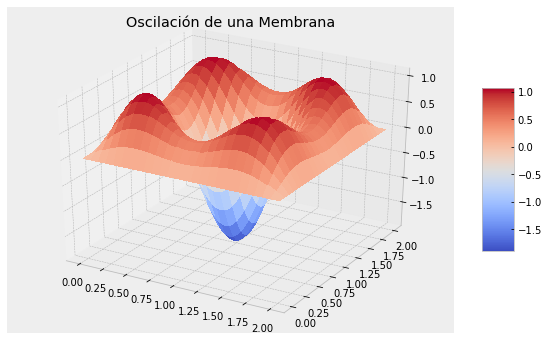

paso: 20.0 t= 0.585


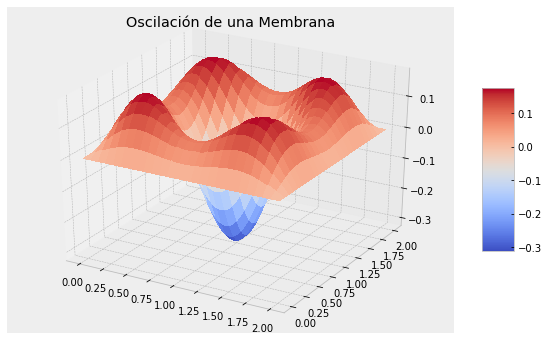

paso: 30.0 t= 0.885


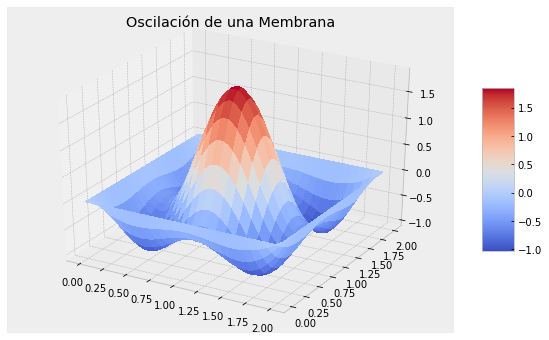

paso: 40.0 t= 1.185


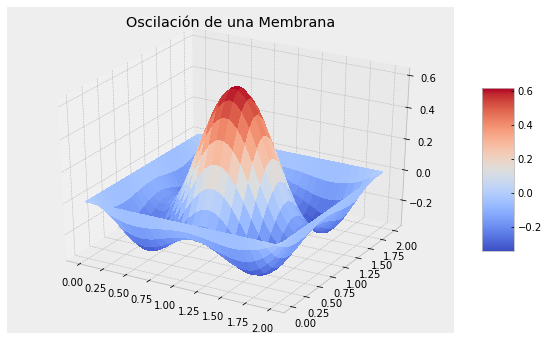

paso: 50.0 t= 1.4849999999999999


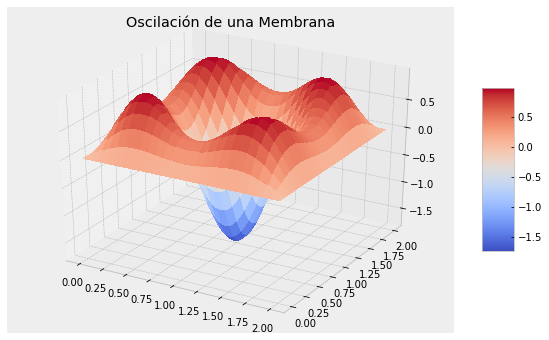

paso: 60.0 t= 1.785


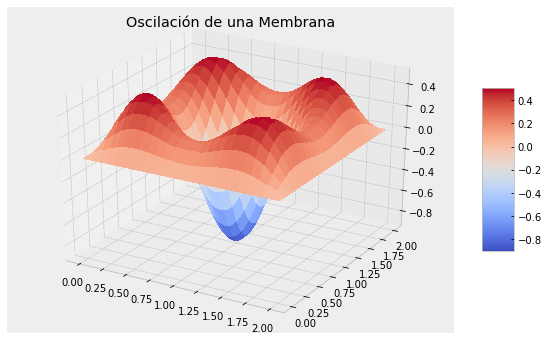

paso: 70.0 t= 2.085


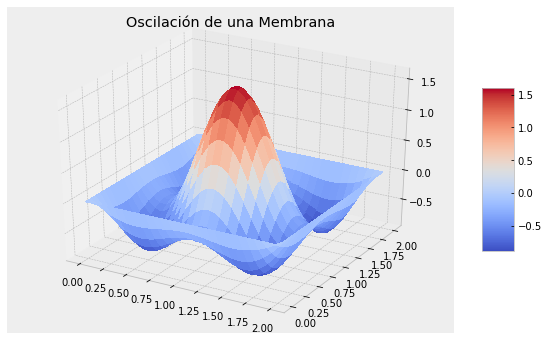

paso: 80.0 t= 2.385


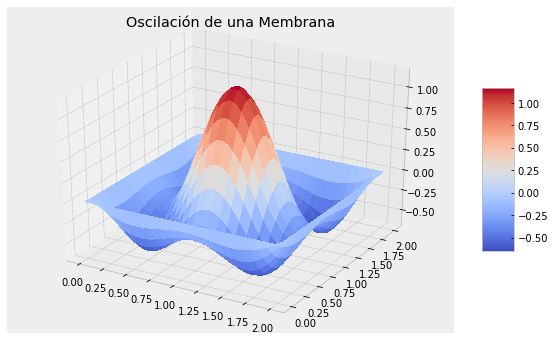

paso: 90.0 t= 2.685


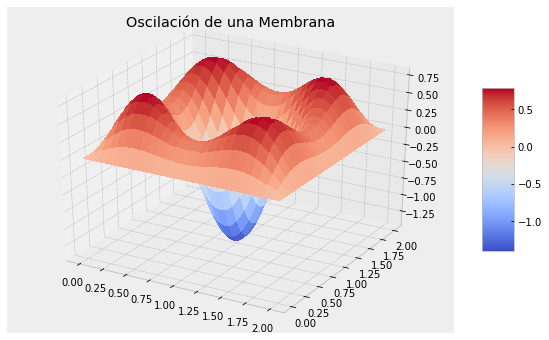

paso: 100.0 t= 2.985


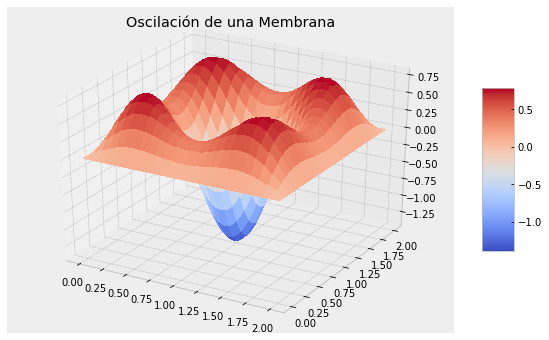

In [16]:
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: 0.1*(np.sin(3*np.pi*r/2)*np.sin(np.pi*s/2)+np.sin(np.pi*r/2)*np.sin(3*np.pi*s/2))
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-1.5, 1.5)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() # No funcionó en Google Colab
    plt.show()
    
if __name__ == "__main__":
    main()